<a href="https://colab.research.google.com/github/Luis-Felipe-Moreira-Sa/tcc_ads/blob/main/tcc_comparacao_temporal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [88]:
!pip install mplfinance

In [89]:
import yfinance as yf
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from scipy.stats import pearsonr
import mplfinance as mpf
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from datetime import date, timedelta

from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler



In [90]:
def download_data_day(ticker, start_date, end_date):
    print("Baixando os dados...")
    data = yf.download(ticker, start_date, end_date, interval='1d')
    return data

# Etapa 2: Pré-processamento dos dados
print("Pré-processando os dados...")
def preprocess_data(data):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))
    return scaled_data, scaler

def create_sequences(data, sequence_length):
    # Etapa 3: Construção do modelo
    print("Construindo o modelo...")
    X, y = [], []
    for i in range(len(data)-sequence_length):
        X.append(data[i:(i+sequence_length), 0])
        y.append(data[i+sequence_length, 0])
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    return X, y

def build_model():
    print("Construindo o modelo SVR...")
    model = SVR(kernel='rbf', C = 5000)  # Você pode escolher o kernel adequado para seu problema
    return model

def train_model(model, X_train, y_train):
    # Reformula os dados de treinamento para que sejam bidimensionais
    X_train_reshaped = X_train.reshape(X_train.shape[0], -1)

    print("Treinando o modelo SVR...")
    model.fit(X_train_reshaped, y_train)
    return model

def predict(model, X_test, scaler=None):
    print("Fazendo as previsões...")
    predicted = model.predict(X_test)
    if scaler is not None:
        predicted = scaler.inverse_transform(predicted.reshape(-1, 1))
    return predicted

def data_training(data):
    sequence_length = 60
    #Pré-processa os dados
    scaled_data, scaler = preprocess_data(data)
    #Cria as sequências de dados
    X, y = create_sequences(scaled_data, sequence_length)
    #Separa os dados de treinamento e teste
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    print(y_train, "   ", y_test)
    return scaled_data, scaler, X_train, X_test, y_train, y_test

def plot_results(actual, predicted, ticker):
    # Etapa 6: Plotando os resultados
    print("Plotando os resultados...")
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111)

    # Define a largura da linha para 1 (você pode ajustar conforme necessário)
    plt.plot(actual, color='blue', label='Actual ' + ticker + ' Price', linewidth=1)
    plt.plot(predicted, color='red', label='Predicted ' + ticker + ' Price', linewidth=1)
    # plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()



def calculate_correlation(actual, predicted):
    # Etapa 7: Cálculo da correlação
    print("Calculando a correlação...")
    corr, _ = pearsonr(actual, predicted)
    return corr


def add_moving_averages(data, window_sizes=[10, 50]):
    for window_size in window_sizes:
        column_name = f'Moving_Average_{window_size}'
        data[column_name] = data['Close'].rolling(window=window_size).mean()
    return data



Pré-processando os dados...


# Download dos Dados

In [91]:
ticker = 'PETR3.SA'
sequence_length = 60
epochs = 20
batch_size = 32

In [92]:
print(ticker)
start_date_day = date.today() - timedelta(days=1915)
end_date_day = date.today() - timedelta(days=91)
data_day = yf.download(tickers=ticker, start=start_date_day, end=end_date_day,interval='1d')
data_test_day = yf.download(tickers=ticker, start=end_date_day, interval='1d')
print(data_day)
print(data_test_day)

PETR3.SA
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2018-07-13  20.610001  20.680000  20.370001  20.580000   7.951938   7731900
2018-07-16  20.530001  20.590000  20.000000  20.379999   7.874659   7373400
2018-07-17  20.250000  21.110001  20.250000  21.059999   8.137404   6790900
2018-07-18  21.000000  21.150000  20.500000  20.650000   7.978983   7857300
2018-07-19  20.450001  20.889999  20.320000  20.889999   8.071717   6164500
...               ...        ...        ...        ...        ...       ...
2023-07-04  33.660000  34.029999  33.529999  33.750000  32.614159   3080800
2023-07-05  33.720001  34.160000  33.320000  33.740002  32.604496  14131000
2023-07-06  33.480000  33.700001  32.930000  33.310001  32.188969  12623600
2023-07-07  33.45

# Dados escalados

In [93]:
scaled_data_1d, scaled_1d, X_train_1d, X_test_1d, y_train_1d, y_test_1d = data_training(data_day)

Construindo o modelo...
[0.59455915 0.61225823 0.57620447 0.55883315 0.58013763 0.61455255
 0.60799736 0.57686    0.58636511 0.61193046 0.59357584 0.56604388
 0.58538181 0.6211078  0.58570958 0.63815141 0.63159616 0.61356931
 0.64241228 0.61651916 0.59488692 0.56342179 0.5598164  0.55522776
 0.51294657 0.52900687 0.55719431 0.55653883 0.53523429 0.53359551
 0.5126188  0.52605702 0.55621107 0.5447394  0.55063912 0.5598164
 0.58603735 0.56932151 0.57489345 0.53588983 0.55063912 0.50540801
 0.49983607 0.50278593 0.50737463 0.50081938 0.49164203 0.46279906
 0.44936085 0.42969515 0.43035069 0.44346113 0.4388725  0.47033756
 0.51130773 0.52933464 0.53949523 0.56866597 0.56374956 0.58243195
 0.57784331 0.5719436  0.56866597 0.56571611 0.57325467 0.58112094
 0.59324807 0.59783678 0.58341526 0.59324807 0.60340866 0.56932151
 0.58964274 0.60275318 0.60635852 0.62176334 0.63290723 0.63913465
 0.62143557 0.6040642  0.59718124 0.58505404 0.61914125 0.64241228
 0.66338905 0.65552272 0.64372336 0.662

# Treinamento do modelo e previsão

In [94]:
epochs = 30
#Constrói o modelo
model_1d = build_model()
#Treina o modelo
model_1d = train_model(model_1d, X_train_1d, y_train_1d)

Construindo o modelo SVR...
Treinando o modelo SVR...


In [95]:
#Faz previsões
# Antes de fazer as previsões, reformule X_test_1d
X_test_1d_reshaped = X_test_1d.reshape(X_test_1d.shape[0], -1)

# Faz previsões
predicted = predict(model_1d, X_test_1d_reshaped, scaled_1d)
print(y_test_1d)
#Desfaz a escala dos dados
y_test_1d = scaled_1d.inverse_transform(y_test_1d.reshape(-1, 1))
print(y_test_1d)

Fazendo as previsões...
[0.84922969 0.8341527  0.83480824 0.82825298 0.84660767 0.86758437
 0.92690923 0.94395271 0.93936407 0.91478197 0.78105539 0.77712216
 0.79023267 0.82858081 0.84431335 0.79514914 0.8135037  0.85775156
 0.86594559 0.85349062 0.86561776 0.89216648 0.82137002 0.85611265
 0.87807273 0.86004588 0.85742373 0.81448707 0.80268764 0.80072102
 0.79580468 0.76073409 0.77450014 0.77187799 0.76565057 0.77908878
 0.77712216 0.77482784 0.798099   0.71615865 0.70239261 0.71517528
 0.70763679 0.70862003 0.72205837 0.81809234 0.79482131 0.83579148
 0.87118977 0.86496222 0.85381833 0.84201903 0.87971151 0.85545724
 0.84759091 0.87479516 0.92068168 0.9550966  1.         0.86529005
 0.84693537 0.82497542 0.82858081 0.81055384 0.72795796 0.73156335
 0.73451321 0.67715497 0.64175674 0.64175674 0.62307435 0.61094722
 0.64405112 0.67191079 0.66043919 0.65257287 0.63389048 0.63028514
 0.52474594 0.52507371 0.55948869 0.53883969 0.56112747 0.60078657
 0.63389048 0.5965257  0.6089806  0.59

Predicted Future com técnica Seed

```
# Isto está formatado como código
```



In [96]:
def predict_future(model, X_test, scaler, n_steps=90):
    if len(X_test) < n_steps:
        n_steps = len(X_test) - 1
    for i in range(n_steps):
        last_90 = X_test[-n_steps:]
        predicted = model.predict(last_90)
        predicted = scaler.inverse_transform(predicted)

        # Adicione apenas o último valor da previsão a X_test
        X_test = np.append(X_test, predicted[0, -1])

    return scaler.inverse_transform(X_test[-n_steps:])



In [97]:
predicted_future = predict_future(model_1d, X_test_1d.reshape(1, -1), scaled_1d)

#RF Regressor

In [98]:
from sklearn.ensemble import RandomForestRegressor

In [99]:
def preprocess_data(data):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))
    return scaled_data, scaler

def create_sequences(data, sequence_length):
    print("Construindo as sequências...")
    X_rf, y_rf = [], []
    for i in range(len(data) - sequence_length):
        X_rf.append(data[i:(i + sequence_length), 0])
        y_rf.append(data[i + sequence_length, 0])
    X_rf, y_rf = np.array(X_rf), np.array(y_rf)
    return X_rf, y_rf

def build_model_rf():
    print("Construindo o modelo Random Forest Regressor...")
    model_rf = RandomForestRegressor(n_estimators=100, random_state=0)  # Você pode ajustar os hiperparâmetros conforme necessário
    return model_rf

def train_model_rf(model_rf, X_train_rf, y_train_rf):
    print("Treinando o modelo Random Forest Regressor...")
    model_rf.fit(X_train_rf, y_train_rf)
    return model_rf

def predict_rf(model_rf, X_test_rf, scaler=None):
    print("Fazendo as previsões com Random Forest Regressor...")
    predicted_rf = model_rf.predict(X_test_rf)
    if scaler is not None:
        predicted_rf = scaler.inverse_transform(predicted_rf.reshape(-1, 1))
    return predicted_rf

def data_training_rf(data_rf):
    sequence_length_rf = 60
    print("Pré-processando os dados...")
    scaled_data_rf, scaler_rf = preprocess_data(data_rf)
    print("Construindo as sequências de dados...")
    X_rf, y_rf = create_sequences(scaled_data_rf, sequence_length_rf)
    train_size_rf = int(len(X_rf) * 0.8)
    X_train_rf, X_test_rf = X_rf[:train_size_rf], X_rf[train_size_rf:]
    y_train_rf, y_test_rf = y_rf[:train_size_rf], y_rf[train_size_rf:]
    return scaled_data_rf, scaler_rf, X_train_rf, X_test_rf, y_train_rf, y_test_rf

def plot_results_rf(actual_rf, predicted_rf, ticker_rf):
    print("Plotando os resultados...")
    fig_rf = plt.figure(figsize=(10, 5))
    ax_rf = fig_rf.add_subplot(111)
    plt.plot(actual_rf, color='blue', label='Actual ' + ticker_rf + ' Price', linewidth=1)
    plt.plot(predicted_rf, color='red', label='Predicted ' + ticker_rf + ' Price', linewidth=1)
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

def calculate_correlation_rf(actual_rf, predicted_rf):
    print("Calculando a correlação...")
    corr_rf, _ = pearsonr(actual_rf, predicted_rf)
    return corr_rf

def add_moving_averages_rf(data_rf, window_sizes_rf=[10, 50]):
    for window_size_rf in window_sizes_rf:
        column_name_rf = f'Moving_Average_{window_size_rf}'
        data_rf[column_name_rf] = data_rf['Close'].rolling(window=window_size_rf).mean()
    return data_rf


#GLM


In [100]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from datetime import date, timedelta

# Função para baixar os dados
def download_data_glm(ticker_glm, start_date_glm, end_date_glm):
    print("Baixando os dados...")
    data_glm = yf.download(ticker_glm, start=start_date_glm, end=end_date_glm, interval='1d')
    return data_glm

# Função para pré-processar os dados
def preprocess_data_glm(data_glm):
    scaler_glm = MinMaxScaler(feature_range=(0, 1))
    scaled_data_glm = scaler_glm.fit_transform(data_glm['Close'].values.reshape(-1, 1))
    return scaled_data_glm, scaler_glm

# Função para criar sequências de dados
def create_sequences_glm(data_glm, sequence_length_glm):
    X_glm, y_glm = [], []
    for i in range(len(data_glm) - sequence_length_glm):
        X_seq_glm = data_glm[i:(i + sequence_length_glm), 0]
        y_seq_glm = data_glm[i + sequence_length_glm, 0]
        X_glm.append(X_seq_glm)
        y_glm.append(y_seq_glm)
    X_glm, y_glm = np.array(X_glm), np.array(y_glm)
    return X_glm, y_glm

# Função para construir o modelo GLM (Regressão Linear)
def build_model_glm():
    return LinearRegression()

# Função para treinar o modelo
def train_model_glm(model_glm, X_train_glm, y_train_glm):
    model_glm.fit(X_train_glm, y_train_glm)
    return model_glm

# Função para fazer previsões
def predict_glm(model_glm, X_test_glm):
    return model_glm.predict(X_test_glm)

# Função para calcular métricas de avaliação
def evaluate_glm(y_true_glm, y_pred_glm):
    mae_glm = mean_absolute_error(y_true_glm, y_pred_glm)
    mse_glm = mean_squared_error(y_true_glm, y_pred_glm)
    rmse_glm = np.sqrt(mse_glm)
    r2_glm = r2_score(y_true_glm, y_pred_glm)
    correlation_glm = np.corrcoef(y_test_glm.flatten(), y_pred_glm.flatten())[0, 1]
    return correlation_glm, mae_glm, mse_glm, rmse_glm, r2_glm

Baixando os dados...
[*********************100%%**********************]  1 of 1 completed
Correlation 0.9670600915837889
MAE: 0.6420999170483935
MSE: 0.7737633691984074
RMSE: 0.8796382035805445
R²: 0.9346381667113799


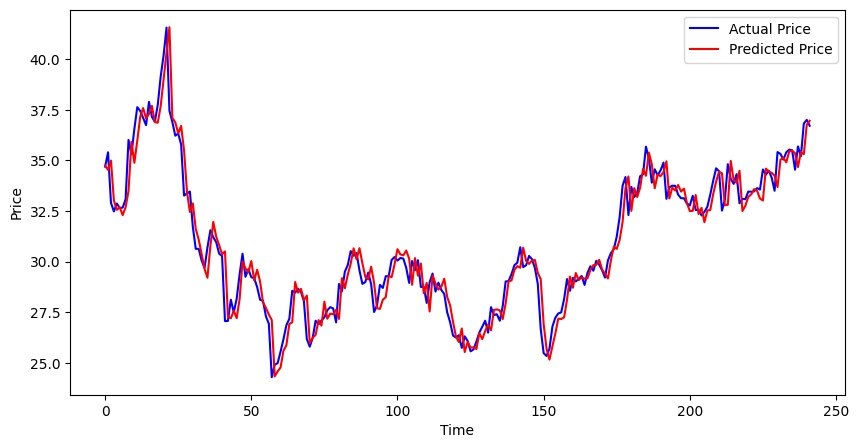

In [101]:
# Parâmetros
ticker_glm = 'PETR3.SA'
start_date_glm = date.today() - timedelta(days=1900)
end_date_glm = date.today() - timedelta(days=30)
sequence_length_glm = 60

# Baixar os dados
data_glm = download_data_glm(ticker_glm, start_date_glm, end_date_glm)

# Pré-processar os dados
scaled_data_glm, scaler_glm = preprocess_data_glm(data_glm)

# Criar sequências de dados
X_glm, y_glm = create_sequences_glm(scaled_data_glm, sequence_length_glm)

# Separar dados de treinamento e teste
train_size_glm = int(len(X_glm) * 0.8)
X_train_glm, X_test_glm = X_glm[:train_size_glm], X_glm[train_size_glm:]
y_train_glm, y_test_glm = y_glm[:train_size_glm], y_glm[train_size_glm:]

# Construir o modelo
model_glm = build_model_glm()

# Treinar o modelo
model_glm = train_model_glm(model_glm, X_train_glm, y_train_glm)

# Fazer previsões
y_pred_glm = predict_glm(model_glm, X_test_glm)

# Desfazer a escala das previsões
y_pred_glm = scaler_glm.inverse_transform(y_pred_glm.reshape(-1, 1))

# Desfazer a escala dos dados de teste
y_test_glm = scaler_glm.inverse_transform(y_test_glm.reshape(-1, 1))

# Calcular métricas de avaliação
correlation_glm, mae_glm, mse_glm, rmse_glm, r2_glm = evaluate_glm(y_test_glm, y_pred_glm)

print("Correlation", correlation_glm)
print("MAE:", mae_glm)
print("MSE:", mse_glm)
print("RMSE:", rmse_glm)
print("R²:", r2_glm)

# Plotar resultados
plt.figure(figsize=(10, 5))
plt.plot(y_test_glm, label='Actual Price', color='blue')
plt.plot(y_pred_glm, label='Predicted Price', color='red')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

PETR3.SA
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Pré-processando os dados...
Construindo as sequências de dados...
Construindo as sequências...
Construindo o modelo Random Forest Regressor...
Treinando o modelo Random Forest Regressor...
Fazendo as previsões com Random Forest Regressor...
Plotando os resultados...


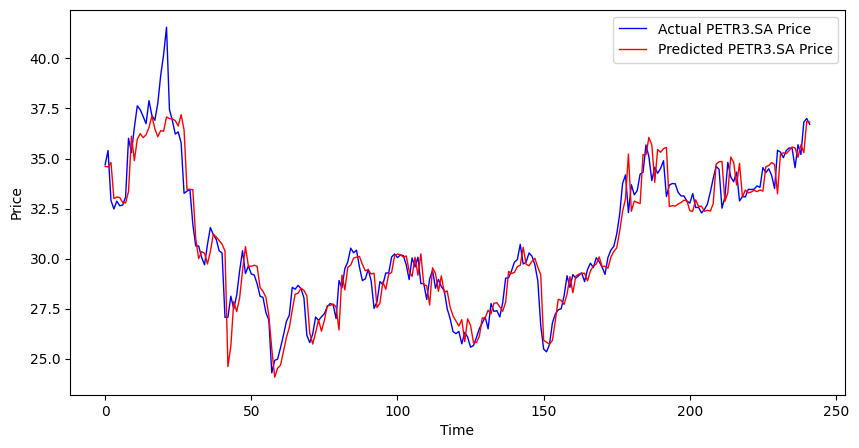

In [102]:
ticker_rf = 'PETR3.SA'
sequence_length_rf = 60

print(ticker_rf)
start_date_day_rf = date.today() - timedelta(days=1900)
end_date_day_rf = date.today() - timedelta(days=30)
data_day_rf = yf.download(tickers=ticker_rf, start=start_date_day_rf, end=end_date_day_rf, interval='1d')
data_test_day_rf = yf.download(tickers=ticker_rf, start=end_date_day_rf, interval='1d')

scaled_data_1d_rf, scaled_1d_rf, X_train_1d_rf, X_test_1d_rf, y_train_1d_rf, y_test_1d_rf = data_training_rf(data_day_rf)

model_1d_rf = build_model_rf()
model_1d_rf = train_model_rf(model_1d_rf, X_train_1d_rf, y_train_1d_rf)

predicted_rf = predict_rf(model_1d_rf, X_test_1d_rf)

# Desfaz a escala dos dados
y_test_1d_rf = scaled_1d_rf.inverse_transform(y_test_1d_rf.reshape(-1, 1))

# Desfaz a escala dos dados
predicted_rf = scaled_1d_rf.inverse_transform(predicted_rf.reshape(-1, 1))

# Plotar resultados
plot_results_rf(y_test_1d_rf, predicted_rf, ticker_rf)

PETR3.SA
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Pré-processando os dados...
Construindo as sequências de dados...
Construindo as sequências...
Construindo o modelo Random Forest Regressor...
Treinando o modelo Random Forest Regressor...
Fazendo as previsões com Random Forest Regressor...
Plotando os resultados...


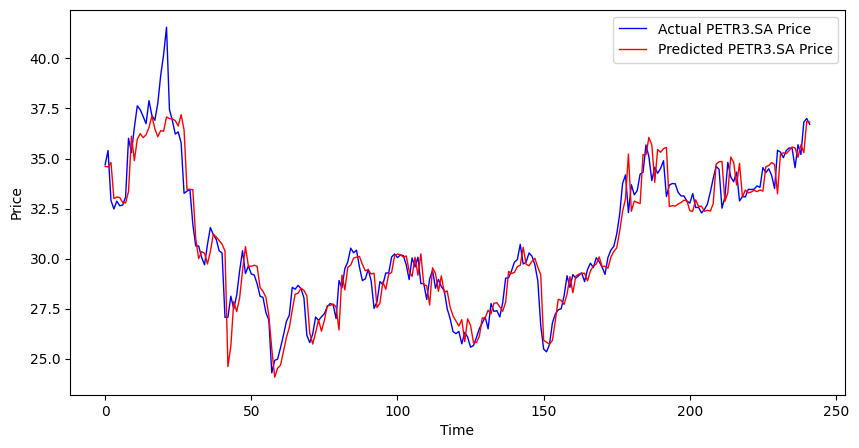

In [103]:
ticker_rf = 'PETR3.SA'
sequence_length_rf = 60

print(ticker_rf)
start_date_day_rf = date.today() - timedelta(days=1900)
end_date_day_rf = date.today() - timedelta(days=30)
data_day_rf = yf.download(tickers=ticker_rf, start=start_date_day_rf, end=end_date_day_rf, interval='1d')
data_test_day_rf = yf.download(tickers=ticker_rf, start=end_date_day_rf, interval='1d')

scaled_data_1d_rf, scaled_1d_rf, X_train_1d_rf, X_test_1d_rf, y_train_1d_rf, y_test_1d_rf = data_training_rf(data_day_rf)

model_1d_rf = build_model_rf()
model_1d_rf = train_model_rf(model_1d_rf, X_train_1d_rf, y_train_1d_rf)

predicted_rf = predict_rf(model_1d_rf, X_test_1d_rf)

# Desfaz a escala dos dados
y_test_1d_rf = scaled_1d_rf.inverse_transform(y_test_1d_rf.reshape(-1, 1))

# Desfaz a escala dos dados
predicted_rf = scaled_1d_rf.inverse_transform(predicted_rf.reshape(-1, 1))

# Plotar resultados
plot_results_rf(y_test_1d_rf, predicted_rf, ticker_rf)

Pré-processando os dados...
Construindo as sequências de dados...
Construindo as sequências...
Construindo o modelo Random Forest Regressor...
Treinando o modelo Random Forest Regressor com médias móveis...
Fazendo as previsões com Random Forest Regressor...
Plotando os resultados...


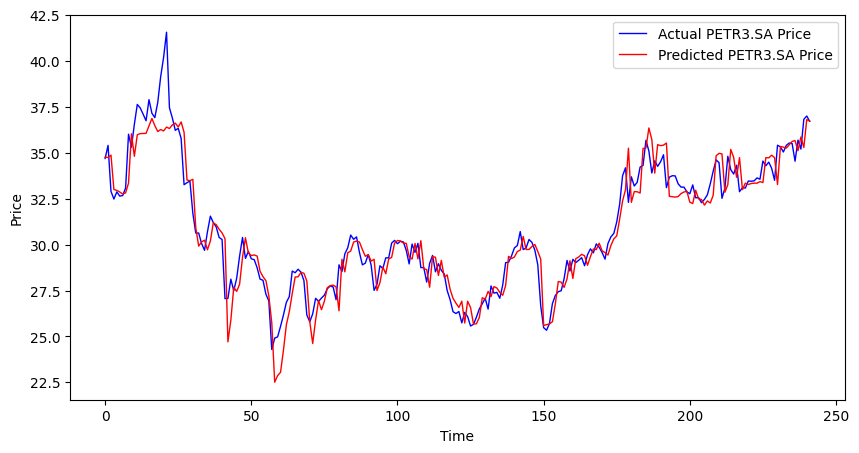

In [104]:
from sklearn.impute import SimpleImputer

def data_training_rf_med(data_rf):
    sequence_length_rf = 60
    print("Pré-processando os dados...")
    scaled_data_rf_med, scaler_rf_med = preprocess_data(data_rf)
    print("Construindo as sequências de dados...")
    X_rf_med, y_rf_med = create_sequences_rf(scaled_data_rf_med, sequence_length_rf)
    train_size_rf_med = int(len(X_rf_med) * 0.8)
    X_train_rf_med, X_test_rf_med = X_rf_med[:train_size_rf_med], X_rf_med[train_size_rf_med:]
    y_train_rf_med, y_test_rf_med = y_rf_med[:train_size_rf_med], y_rf_med[train_size_rf_med:]

    # Tratar valores ausentes
    imputer = SimpleImputer(strategy='mean')
    X_train_rf_med = imputer.fit_transform(X_train_rf_med)
    X_test_rf_med = imputer.transform(X_test_rf_med)

    return scaled_data_rf_med, scaler_rf_med, X_train_rf_med, X_test_rf_med, y_train_rf_med, y_test_rf_med

def create_sequences_rf(data_rf, sequence_length_rf):
    print("Construindo as sequências...")
    X_rf_med, y_rf_med = [], []
    for i in range(len(data_rf) - sequence_length_rf):
        X_seq_rf = data_rf[i:(i + sequence_length_rf), 0]

        # Adiciona as médias móveis como atributos adicionais
        for window_size_rf in [10, 50]:
            rolling_mean = pd.Series(data_rf[i:(i + sequence_length_rf), 0]).rolling(window=window_size_rf).mean()
            X_seq_rf = np.append(X_seq_rf, rolling_mean)

        X_rf_med.append(X_seq_rf)
        y_rf_med.append(data_rf[i + sequence_length_rf, 0])
    X_rf_med, y_rf_med = np.array(X_rf_med), np.array(y_rf_med)
    return X_rf_med, y_rf_med

def build_model_rf_med():
    print("Construindo o modelo Random Forest Regressor com médias móveis...")
    model_rf_med = RandomForestRegressor(n_estimators=100, random_state=0)  # Você pode ajustar os hiperparâmetros conforme necessário
    return model_rf_med

def train_model_rf_med(model_rf_med, X_train_rf_med, y_train_rf_med):
    print("Treinando o modelo Random Forest Regressor com médias móveis...")
    model_rf_med.fit(X_train_rf_med, y_train_rf_med)
    return model_rf_med

def predict_rf_med(model_rf_med, X_test_rf_med, scaler=None):
    print("Fazendo as previsões com Random Forest Regressor com médias móveis...")
    predicted_rf_med = model_rf_med.predict(X_test_rf_med)
    if scaler is not None:
        predicted_rf_med = scaler.inverse_transform(predicted_rf_med.reshape(-1, 1))
    return predicted_rf_med

def calculate_correlation_rf_med(actual_rf_med, predicted_rf_med):
    print("Calculando a correlação com Random Forest Regressor com médias móveis...")
    corr_rf_med, _ = pearsonr(actual_rf_med, predicted_rf_med)
    return corr_rf_med

def add_moving_averages_rf_med(data_rf, window_sizes_rf=[10, 50]):
    for window_size_rf in window_sizes_rf:
        column_name_rf = f'Moving_Average_{window_size_rf}_rf_med'
        data_rf[column_name_rf] = data_rf['Close'].rolling(window=window_size_rf).mean()
    return data_rf
# ...

# Treinamento do modelo Random Forest Regressor com médias móveis
scaled_data_1d_rf_med, scaled_1d_rf_med, X_train_1d_rf_med, X_test_1d_rf_med, y_train_1d_rf_med, y_test_1d_rf_med = data_training_rf_med(data_day_rf)

model_1d_rf_med = build_model_rf()
model_1d_rf_med = train_model_rf_med(model_1d_rf_med, X_train_1d_rf_med, y_train_1d_rf_med)

predicted_rf_med = predict_rf(model_1d_rf_med, X_test_1d_rf_med)

# Desfaz a escala dos dados
y_test_1d_rf_med = scaled_1d_rf_med.inverse_transform(y_test_1d_rf_med.reshape(-1, 1))

# Desfaz a escala dos dados
predicted_rf_med = scaled_1d_rf_med.inverse_transform(predicted_rf_med.reshape(-1, 1))

# Plotar resultados
plot_results_rf(y_test_1d_rf_med, predicted_rf_med, ticker_rf)


# Plotando *dados*

Plotando os resultados...


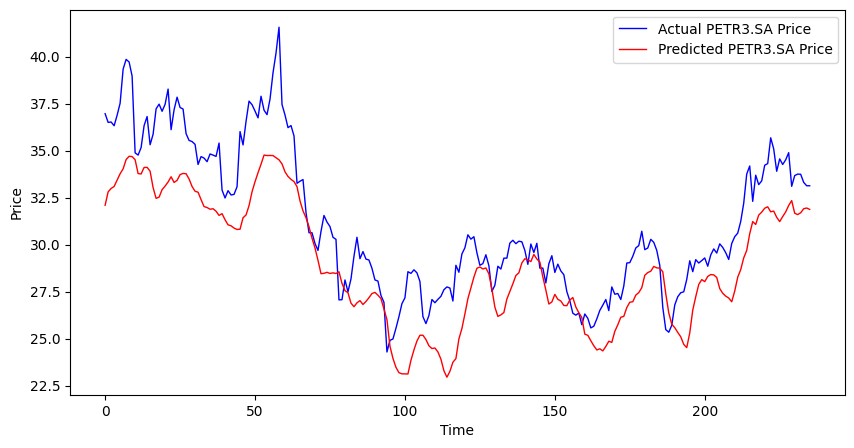

In [105]:
plot_results(y_test_1d, predicted, ticker)

# Correlação

In [106]:
def calculate_correlation(predicted_future, y_test_1d):
    # Calcular a correlação entre predicted_future e y_test_1d
    correlation = pd.Series(predicted_future).corr(pd.Series(y_test_1d))

    return correlation

In [107]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import math


In [108]:
# print(" Length of y_test_1d:", len(y_test_1d))
# print(" Length of predicted:", len(predicted))

# Reshape both arrays to have compatible shapes for correlation calculation
y_test_1d = y_test_1d.reshape(-1)  # Flatten y_test_1d
predicted = predicted.reshape(-1)  # Flatten y_test_future

# Now both arrays should have the same shape and can be used for correlation calculation
correlation = calculate_correlation(y_test_1d, predicted)
print(f"A correlação entre y_test_1d e predicted é: {correlation}")

# Calcular o Erro Médio Absoluto (MAE)
mae = mean_absolute_error(y_test_1d, predicted)
print(f"MAE: {mae}")

# Calcular o Erro Médio Quadrático (MSE)
mse = mean_squared_error(y_test_1d, predicted)
print(f"MSE: {mse}")

# Calcular a Raiz do Erro Médio Quadrático (RMSE)
rmse = math.sqrt(mse)
print(f"RMSE: {rmse}")

# Calcular o R² (Coeficiente de Determinação)
r2 = r2_score(y_test_1d, predicted)
print(f"R²: {r2}")

A correlação entre y_test_1d e predicted é: 0.9245373827749928
MAE: 2.2646790060906294
MSE: 7.000291782749207
RMSE: 2.6458064522464992
R²: 0.5389494857236146


In [109]:
# Reshape both arrays to have compatible shapes for correlation calculation
y_test_1d = y_test_1d.reshape(-1)  # Flatten y_test_1d
predicted = predicted.reshape(-1)  # Flatten y_test_future
# Métricas do SVR
corr_svr = calculate_correlation(predicted, y_test_1d)
mae_svr = mean_absolute_error(y_test_1d, predicted)
mse_svr = mean_squared_error(y_test_1d, predicted)
rmse_svr = math.sqrt(mse_svr)
r2_svr = r2_score(y_test_1d, predicted)

y_test_1d_rf = y_test_1d_rf.reshape(-1)  # Flatten y_test_1d
predicted_rf = predicted_rf.reshape(-1)  # Flatten y_test_future
# Métricas do Random Forest Regressor
corr_rf = calculate_correlation_rf(predicted_rf, y_test_1d_rf)
mae_rf = mean_absolute_error(y_test_1d_rf, predicted_rf)
mse_rf = mean_squared_error(y_test_1d_rf, predicted_rf)
rmse_rf = math.sqrt(mse_rf)
r2_rf = r2_score(y_test_1d_rf, predicted_rf)


# Reshape both arrays to have compatible shapes for correlation calculation
y_test_1d_rf_med = y_test_1d_rf_med.reshape(-1)  # Flatten y_test_1d
predicted_rf_med = predicted_rf_med.reshape(-1)  # Flatten y_test_future

# Métricas do Random Forest Regressor com medias moveis
corr_rf_med = calculate_correlation_rf(predicted_rf_med, y_test_1d_rf_med)
mae_rf_med = mean_absolute_error(y_test_1d_rf_med, predicted_rf_med)
mse_rf_med = mean_squared_error(y_test_1d_rf_med, predicted_rf_med)
rmse_rf_med = math.sqrt(mse_rf)
r2_rf_med = r2_score(y_test_1d_rf, predicted_rf_med)

# Criar um DataFrame para comparar as métricas
data = {
    'Métrica': ['Correlação', 'MAE', 'MSE', 'RMSE', 'R²'],
    'SVR': [corr_svr, mae_svr, mse_svr, rmse_svr, r2_svr],
    'Random Forest': [corr_rf, mae_rf, mse_rf, rmse_rf, r2_rf],
    'Random Forest_Medias': [corr_rf_med, mae_rf_med, mse_rf_med, rmse_rf_med, r2_rf_med],
    'GLM': [correlation_glm, mae_glm, mse_glm, rmse_glm, r2_glm]
}

print("\t\t", ticker)
df_metrics = pd.DataFrame(data)
data_petr4 = df_metrics
display(df_metrics)

Calculando a correlação...
Calculando a correlação...
		 PETR3.SA


,Métrica,SVR,Random Forest,Random Forest_Medias,GLM
0,Correlação,0.924537,0.956647,0.952175,0.967060
1,MAE,2.264679,0.716321,0.753201,0.642100
2,MSE,7.000292,1.010458,1.133398,0.773763
3,RMSE,2.645806,1.005215,1.005215,0.879638
4,R²,0.538949,0.914644,0.904259,0.934638


#BOVA11

Pré-processando os dados...
BOVA11.SA
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2018-07-13   73.339996   74.010002   72.889999   74.010002   74.010002   
2018-07-16   73.870003   74.260002   73.449997   73.949997   73.949997   
2018-07-17   73.989998   75.800003   73.989998   75.370003   75.370003   
2018-07-18   75.389999   75.650002   74.440002   74.660004   74.660004   
2018-07-19   73.889999   74.650002   73.239998   74.650002   74.650002   
...                ...         ...         ...         ...         ...   
2023-07-04  115.620003  115.919998  115.029999  115.239998  115.239998   
2023-07-05  114.849998  118.059998  114.849998  115.839996  115.839996   
2023-07-06  114.849998  115.129997  113.430000  113.639999  113.639999   
2023-07-07

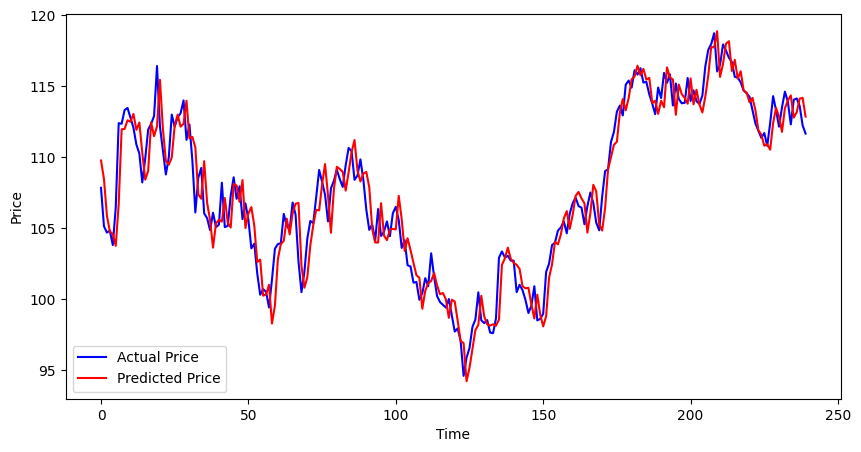

BOVA11.SA
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Pré-processando os dados...
Construindo as sequências de dados...
Construindo as sequências...
Construindo o modelo Random Forest Regressor...
Treinando o modelo Random Forest Regressor...
Fazendo as previsões com Random Forest Regressor...
Plotando os resultados...


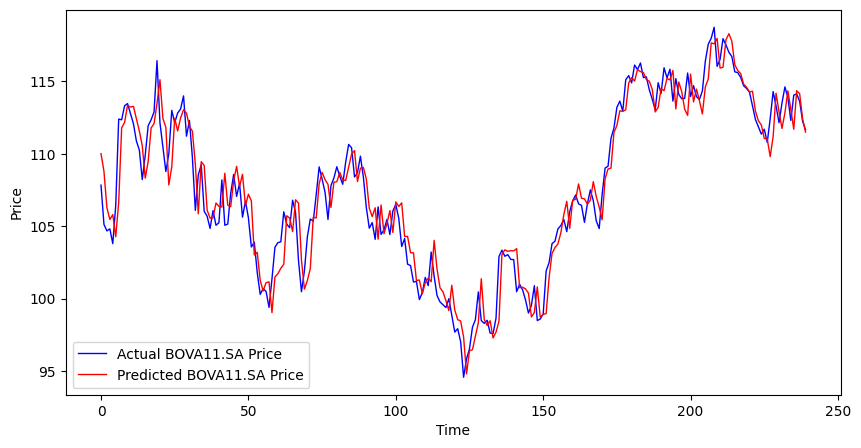

BOVA11.SA
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Pré-processando os dados...
Construindo as sequências de dados...
Construindo as sequências...
Construindo o modelo Random Forest Regressor...
Treinando o modelo Random Forest Regressor...
Fazendo as previsões com Random Forest Regressor...
Plotando os resultados...


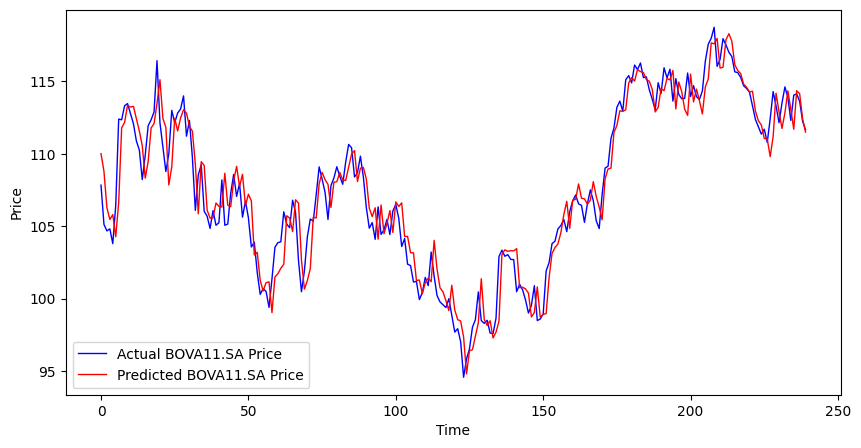

Pré-processando os dados...
Construindo as sequências de dados...
Construindo as sequências...
Construindo o modelo Random Forest Regressor...
Treinando o modelo Random Forest Regressor com médias móveis...
Fazendo as previsões com Random Forest Regressor...
Plotando os resultados...


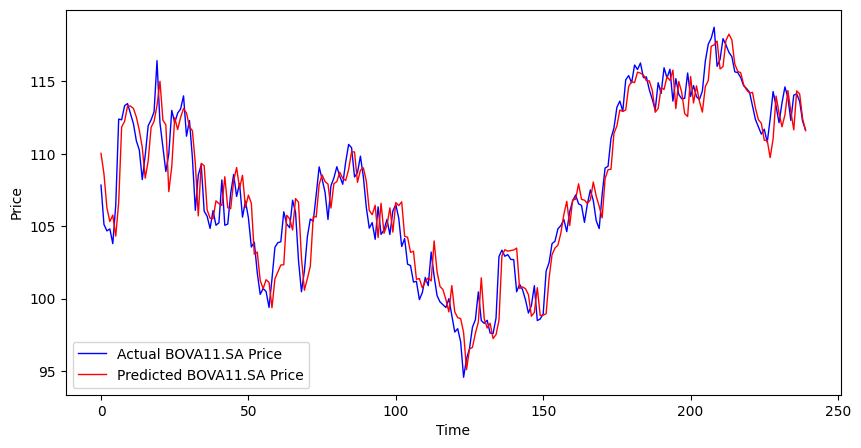

Plotando os resultados...


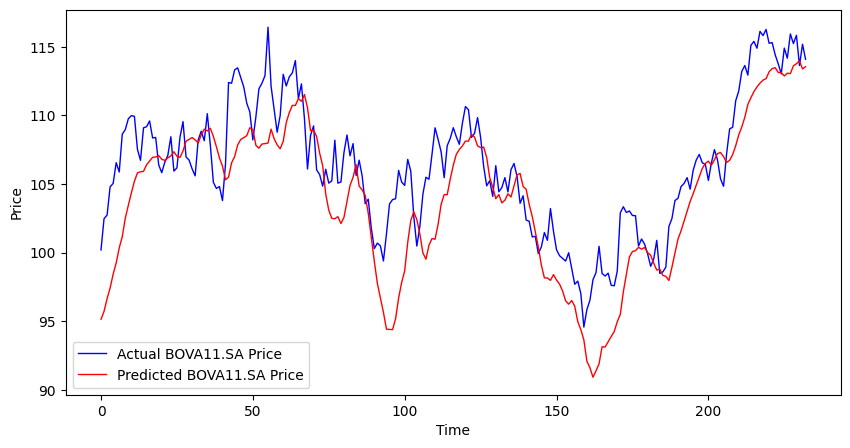

A correlação entre y_test_1d e predicted é: 0.8664369020743319
MAE: 2.789976368257622
MSE: 12.474778529776033
RMSE: 3.5319652503636036
R²: 0.46666039517670643
Calculando a correlação...
Calculando a correlação...


,Métrica,SVR,Random Forest,Random Forest_Medias,GLM
0,Correlação,0.866437,0.960445,0.960390,0.960175
1,MAE,2.789976,1.240279,1.246014,1.262398
2,MSE,12.474779,2.521467,2.521879,2.579649
3,RMSE,3.531965,1.587913,1.587913,1.606129
4,R²,0.466660,0.922304,0.922291,0.920511


In [110]:
# -*- coding: utf-8 -*-
"""svr.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1KjiimiSBdMdGFPkNaAOG8qm_oOgiIemH
"""

!pip install mplfinance

import yfinance as yf
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from scipy.stats import pearsonr
import mplfinance as mpf
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from datetime import date, timedelta

from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

def download_data_day(ticker, start_date, end_date):
    print("Baixando os dados...")
    data = yf.download(ticker, start_date, end_date, interval='1d')
    return data

# Etapa 2: Pré-processamento dos dados
print("Pré-processando os dados...")
def preprocess_data(data):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))
    return scaled_data, scaler

def create_sequences(data, sequence_length):
    # Etapa 3: Construção do modelo
    print("Construindo o modelo...")
    X, y = [], []
    for i in range(len(data)-sequence_length):
        X.append(data[i:(i+sequence_length), 0])
        y.append(data[i+sequence_length, 0])
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    return X, y

def build_model():
    print("Construindo o modelo SVR...")
    model = SVR(kernel='rbf', C = 5000)  # Você pode escolher o kernel adequado para seu problema
    return model

def train_model(model, X_train, y_train):
    # Reformula os dados de treinamento para que sejam bidimensionais
    X_train_reshaped = X_train.reshape(X_train.shape[0], -1)

    print("Treinando o modelo SVR...")
    model.fit(X_train_reshaped, y_train)
    return model

def predict(model, X_test, scaler=None):
    print("Fazendo as previsões...")
    predicted = model.predict(X_test)
    if scaler is not None:
        predicted = scaler.inverse_transform(predicted.reshape(-1, 1))
    return predicted

def data_training(data):
    sequence_length = 60
    #Pré-processa os dados
    scaled_data, scaler = preprocess_data(data)
    #Cria as sequências de dados
    X, y = create_sequences(scaled_data, sequence_length)
    #Separa os dados de treinamento e teste
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    print(y_train, "   ", y_test)
    return scaled_data, scaler, X_train, X_test, y_train, y_test

def plot_results(actual, predicted, ticker):
    # Etapa 6: Plotando os resultados
    print("Plotando os resultados...")
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111)

    # Define a largura da linha para 1 (você pode ajustar conforme necessário)
    plt.plot(actual, color='blue', label='Actual ' + ticker + ' Price', linewidth=1)
    plt.plot(predicted, color='red', label='Predicted ' + ticker + ' Price', linewidth=1)
    # plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()



def calculate_correlation(actual, predicted):
    # Etapa 7: Cálculo da correlação
    print("Calculando a correlação...")
    corr, _ = pearsonr(actual, predicted)
    return corr


def add_moving_averages(data, window_sizes=[10, 50]):
    for window_size in window_sizes:
        column_name = f'Moving_Average_{window_size}'
        data[column_name] = data['Close'].rolling(window=window_size).mean()
    return data

"""# Download dos Dados"""

ticker = 'BOVA11.SA'
sequence_length = 60
epochs = 20
batch_size = 32

print(ticker)
start_date_day = date.today() - timedelta(days=1915)
end_date_day = date.today() - timedelta(days=91)
data_day = yf.download(tickers=ticker, start=start_date_day, end=end_date_day,interval='1d')
data_test_day = yf.download(tickers=ticker, start=end_date_day, interval='1d')
print(data_day)
print(data_test_day)

"""# Dados escalados"""

scaled_data_1d, scaled_1d, X_train_1d, X_test_1d, y_train_1d, y_test_1d = data_training(data_day)

"""# Treinamento do modelo e previsão"""

epochs = 30
#Constrói o modelo
model_1d = build_model()
#Treina o modelo
model_1d = train_model(model_1d, X_train_1d, y_train_1d)

#Faz previsões
# Antes de fazer as previsões, reformule X_test_1d
X_test_1d_reshaped = X_test_1d.reshape(X_test_1d.shape[0], -1)

# Faz previsões
predicted = predict(model_1d, X_test_1d_reshaped, scaled_1d)
print(y_test_1d)
#Desfaz a escala dos dados
y_test_1d = scaled_1d.inverse_transform(y_test_1d.reshape(-1, 1))
print(y_test_1d)

"""Predicted Future com técnica Seed

```
# Isto está formatado como código
```


"""

def predict_future(model, X_test, scaler, n_steps=90):
    if len(X_test) < n_steps:
        n_steps = len(X_test) - 1
    for i in range(n_steps):
        last_90 = X_test[-n_steps:]
        predicted = model.predict(last_90)
        predicted = scaler.inverse_transform(predicted)

        # Adicione apenas o último valor da previsão a X_test
        X_test = np.append(X_test, predicted[0, -1])

    return scaler.inverse_transform(X_test[-n_steps:])

predicted_future = predict_future(model_1d, X_test_1d.reshape(1, -1), scaled_1d)

"""#RF Regressor"""

from sklearn.ensemble import RandomForestRegressor

def preprocess_data(data):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))
    return scaled_data, scaler

def create_sequences(data, sequence_length):
    print("Construindo as sequências...")
    X_rf, y_rf = [], []
    for i in range(len(data) - sequence_length):
        X_rf.append(data[i:(i + sequence_length), 0])
        y_rf.append(data[i + sequence_length, 0])
    X_rf, y_rf = np.array(X_rf), np.array(y_rf)
    return X_rf, y_rf

def build_model_rf():
    print("Construindo o modelo Random Forest Regressor...")
    model_rf = RandomForestRegressor(n_estimators=100, random_state=0)  # Você pode ajustar os hiperparâmetros conforme necessário
    return model_rf

def train_model_rf(model_rf, X_train_rf, y_train_rf):
    print("Treinando o modelo Random Forest Regressor...")
    model_rf.fit(X_train_rf, y_train_rf)
    return model_rf

def predict_rf(model_rf, X_test_rf, scaler=None):
    print("Fazendo as previsões com Random Forest Regressor...")
    predicted_rf = model_rf.predict(X_test_rf)
    if scaler is not None:
        predicted_rf = scaler.inverse_transform(predicted_rf.reshape(-1, 1))
    return predicted_rf

def data_training_rf(data_rf):
    sequence_length_rf = 60
    print("Pré-processando os dados...")
    scaled_data_rf, scaler_rf = preprocess_data(data_rf)
    print("Construindo as sequências de dados...")
    X_rf, y_rf = create_sequences(scaled_data_rf, sequence_length_rf)
    train_size_rf = int(len(X_rf) * 0.8)
    X_train_rf, X_test_rf = X_rf[:train_size_rf], X_rf[train_size_rf:]
    y_train_rf, y_test_rf = y_rf[:train_size_rf], y_rf[train_size_rf:]
    return scaled_data_rf, scaler_rf, X_train_rf, X_test_rf, y_train_rf, y_test_rf

def plot_results_rf(actual_rf, predicted_rf, ticker_rf):
    print("Plotando os resultados...")
    fig_rf = plt.figure(figsize=(10, 5))
    ax_rf = fig_rf.add_subplot(111)
    plt.plot(actual_rf, color='blue', label='Actual ' + ticker_rf + ' Price', linewidth=1)
    plt.plot(predicted_rf, color='red', label='Predicted ' + ticker_rf + ' Price', linewidth=1)
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

def calculate_correlation_rf(actual_rf, predicted_rf):
    print("Calculando a correlação...")
    corr_rf, _ = pearsonr(actual_rf, predicted_rf)
    return corr_rf

def add_moving_averages_rf(data_rf, window_sizes_rf=[10, 50]):
    for window_size_rf in window_sizes_rf:
        column_name_rf = f'Moving_Average_{window_size_rf}'
        data_rf[column_name_rf] = data_rf['Close'].rolling(window=window_size_rf).mean()
    return data_rf

"""#GLM

"""

import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from datetime import date, timedelta

# Função para baixar os dados
def download_data_glm(ticker_glm, start_date_glm, end_date_glm):
    print("Baixando os dados...")
    data_glm = yf.download(ticker_glm, start=start_date_glm, end=end_date_glm, interval='1d')
    return data_glm

# Função para pré-processar os dados
def preprocess_data_glm(data_glm):
    scaler_glm = MinMaxScaler(feature_range=(0, 1))
    scaled_data_glm = scaler_glm.fit_transform(data_glm['Close'].values.reshape(-1, 1))
    return scaled_data_glm, scaler_glm

# Função para criar sequências de dados
def create_sequences_glm(data_glm, sequence_length_glm):
    X_glm, y_glm = [], []
    for i in range(len(data_glm) - sequence_length_glm):
        X_seq_glm = data_glm[i:(i + sequence_length_glm), 0]
        y_seq_glm = data_glm[i + sequence_length_glm, 0]
        X_glm.append(X_seq_glm)
        y_glm.append(y_seq_glm)
    X_glm, y_glm = np.array(X_glm), np.array(y_glm)
    return X_glm, y_glm

# Função para construir o modelo GLM (Regressão Linear)
def build_model_glm():
    return LinearRegression()

# Função para treinar o modelo
def train_model_glm(model_glm, X_train_glm, y_train_glm):
    model_glm.fit(X_train_glm, y_train_glm)
    return model_glm

# Função para fazer previsões
def predict_glm(model_glm, X_test_glm):
    return model_glm.predict(X_test_glm)

# Função para calcular métricas de avaliação
def evaluate_glm(y_true_glm, y_pred_glm):
    mae_glm = mean_absolute_error(y_true_glm, y_pred_glm)
    mse_glm = mean_squared_error(y_true_glm, y_pred_glm)
    rmse_glm = np.sqrt(mse_glm)
    r2_glm = r2_score(y_true_glm, y_pred_glm)
    correlation_glm = np.corrcoef(y_test_glm.flatten(), y_pred_glm.flatten())[0, 1]
    return correlation_glm, mae_glm, mse_glm, rmse_glm, r2_glm

# Parâmetros
ticker_glm = 'BOVA11.SA'
start_date_glm = date.today() - timedelta(days=1900)
end_date_glm = date.today() - timedelta(days=30)
sequence_length_glm = 60

# Baixar os dados
data_glm = download_data_glm(ticker_glm, start_date_glm, end_date_glm)

# Pré-processar os dados
scaled_data_glm, scaler_glm = preprocess_data_glm(data_glm)

# Criar sequências de dados
X_glm, y_glm = create_sequences_glm(scaled_data_glm, sequence_length_glm)

# Separar dados de treinamento e teste
train_size_glm = int(len(X_glm) * 0.8)
X_train_glm, X_test_glm = X_glm[:train_size_glm], X_glm[train_size_glm:]
y_train_glm, y_test_glm = y_glm[:train_size_glm], y_glm[train_size_glm:]

# Construir o modelo
model_glm = build_model_glm()

# Treinar o modelo
model_glm = train_model_glm(model_glm, X_train_glm, y_train_glm)

# Fazer previsões
y_pred_glm = predict_glm(model_glm, X_test_glm)

# Desfazer a escala das previsões
y_pred_glm = scaler_glm.inverse_transform(y_pred_glm.reshape(-1, 1))

# Desfazer a escala dos dados de teste
y_test_glm = scaler_glm.inverse_transform(y_test_glm.reshape(-1, 1))

# Calcular métricas de avaliação
correlation_glm, mae_glm, mse_glm, rmse_glm, r2_glm = evaluate_glm(y_test_glm, y_pred_glm)

print("Correlation", correlation_glm)
print("MAE:", mae_glm)
print("MSE:", mse_glm)
print("RMSE:", rmse_glm)
print("R²:", r2_glm)

# Plotar resultados
plt.figure(figsize=(10, 5))
plt.plot(y_test_glm, label='Actual Price', color='blue')
plt.plot(y_pred_glm, label='Predicted Price', color='red')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

ticker_rf = 'BOVA11.SA'
sequence_length_rf = 60

print(ticker_rf)
start_date_day_rf = date.today() - timedelta(days=1900)
end_date_day_rf = date.today() - timedelta(days=30)
data_day_rf = yf.download(tickers=ticker_rf, start=start_date_day_rf, end=end_date_day_rf, interval='1d')
data_test_day_rf = yf.download(tickers=ticker_rf, start=end_date_day_rf, interval='1d')

scaled_data_1d_rf, scaled_1d_rf, X_train_1d_rf, X_test_1d_rf, y_train_1d_rf, y_test_1d_rf = data_training_rf(data_day_rf)

model_1d_rf = build_model_rf()
model_1d_rf = train_model_rf(model_1d_rf, X_train_1d_rf, y_train_1d_rf)

predicted_rf = predict_rf(model_1d_rf, X_test_1d_rf)

# Desfaz a escala dos dados
y_test_1d_rf = scaled_1d_rf.inverse_transform(y_test_1d_rf.reshape(-1, 1))

# Desfaz a escala dos dados
predicted_rf = scaled_1d_rf.inverse_transform(predicted_rf.reshape(-1, 1))

# Plotar resultados
plot_results_rf(y_test_1d_rf, predicted_rf, ticker_rf)

ticker_rf = 'BOVA11.SA'
sequence_length_rf = 60

print(ticker_rf)
start_date_day_rf = date.today() - timedelta(days=1900)
end_date_day_rf = date.today() - timedelta(days=30)
data_day_rf = yf.download(tickers=ticker_rf, start=start_date_day_rf, end=end_date_day_rf, interval='1d')
data_test_day_rf = yf.download(tickers=ticker_rf, start=end_date_day_rf, interval='1d')

scaled_data_1d_rf, scaled_1d_rf, X_train_1d_rf, X_test_1d_rf, y_train_1d_rf, y_test_1d_rf = data_training_rf(data_day_rf)

model_1d_rf = build_model_rf()
model_1d_rf = train_model_rf(model_1d_rf, X_train_1d_rf, y_train_1d_rf)

predicted_rf = predict_rf(model_1d_rf, X_test_1d_rf)

# Desfaz a escala dos dados
y_test_1d_rf = scaled_1d_rf.inverse_transform(y_test_1d_rf.reshape(-1, 1))

# Desfaz a escala dos dados
predicted_rf = scaled_1d_rf.inverse_transform(predicted_rf.reshape(-1, 1))

# Plotar resultados
plot_results_rf(y_test_1d_rf, predicted_rf, ticker_rf)

from sklearn.impute import SimpleImputer

def data_training_rf_med(data_rf):
    sequence_length_rf = 60
    print("Pré-processando os dados...")
    scaled_data_rf_med, scaler_rf_med = preprocess_data(data_rf)
    print("Construindo as sequências de dados...")
    X_rf_med, y_rf_med = create_sequences_rf(scaled_data_rf_med, sequence_length_rf)
    train_size_rf_med = int(len(X_rf_med) * 0.8)
    X_train_rf_med, X_test_rf_med = X_rf_med[:train_size_rf_med], X_rf_med[train_size_rf_med:]
    y_train_rf_med, y_test_rf_med = y_rf_med[:train_size_rf_med], y_rf_med[train_size_rf_med:]

    # Tratar valores ausentes
    imputer = SimpleImputer(strategy='mean')
    X_train_rf_med = imputer.fit_transform(X_train_rf_med)
    X_test_rf_med = imputer.transform(X_test_rf_med)

    return scaled_data_rf_med, scaler_rf_med, X_train_rf_med, X_test_rf_med, y_train_rf_med, y_test_rf_med

def create_sequences_rf(data_rf, sequence_length_rf):
    print("Construindo as sequências...")
    X_rf_med, y_rf_med = [], []
    for i in range(len(data_rf) - sequence_length_rf):
        X_seq_rf = data_rf[i:(i + sequence_length_rf), 0]

        # Adiciona as médias móveis como atributos adicionais
        for window_size_rf in [10, 50]:
            rolling_mean = pd.Series(data_rf[i:(i + sequence_length_rf), 0]).rolling(window=window_size_rf).mean()
            X_seq_rf = np.append(X_seq_rf, rolling_mean)

        X_rf_med.append(X_seq_rf)
        y_rf_med.append(data_rf[i + sequence_length_rf, 0])
    X_rf_med, y_rf_med = np.array(X_rf_med), np.array(y_rf_med)
    return X_rf_med, y_rf_med

def build_model_rf_med():
    print("Construindo o modelo Random Forest Regressor com médias móveis...")
    model_rf_med = RandomForestRegressor(n_estimators=100, random_state=0)  # Você pode ajustar os hiperparâmetros conforme necessário
    return model_rf_med

def train_model_rf_med(model_rf_med, X_train_rf_med, y_train_rf_med):
    print("Treinando o modelo Random Forest Regressor com médias móveis...")
    model_rf_med.fit(X_train_rf_med, y_train_rf_med)
    return model_rf_med

def predict_rf_med(model_rf_med, X_test_rf_med, scaler=None):
    print("Fazendo as previsões com Random Forest Regressor com médias móveis...")
    predicted_rf_med = model_rf_med.predict(X_test_rf_med)
    if scaler is not None:
        predicted_rf_med = scaler.inverse_transform(predicted_rf_med.reshape(-1, 1))
    return predicted_rf_med

def calculate_correlation_rf_med(actual_rf_med, predicted_rf_med):
    print("Calculando a correlação com Random Forest Regressor com médias móveis...")
    corr_rf_med, _ = pearsonr(actual_rf_med, predicted_rf_med)
    return corr_rf_med

def add_moving_averages_rf_med(data_rf, window_sizes_rf=[10, 50]):
    for window_size_rf in window_sizes_rf:
        column_name_rf = f'Moving_Average_{window_size_rf}_rf_med'
        data_rf[column_name_rf] = data_rf['Close'].rolling(window=window_size_rf).mean()
    return data_rf
# ...

# Treinamento do modelo Random Forest Regressor com médias móveis
scaled_data_1d_rf_med, scaled_1d_rf_med, X_train_1d_rf_med, X_test_1d_rf_med, y_train_1d_rf_med, y_test_1d_rf_med = data_training_rf_med(data_day_rf)

model_1d_rf_med = build_model_rf()
model_1d_rf_med = train_model_rf_med(model_1d_rf_med, X_train_1d_rf_med, y_train_1d_rf_med)

predicted_rf_med = predict_rf(model_1d_rf_med, X_test_1d_rf_med)

# Desfaz a escala dos dados
y_test_1d_rf_med = scaled_1d_rf_med.inverse_transform(y_test_1d_rf_med.reshape(-1, 1))

# Desfaz a escala dos dados
predicted_rf_med = scaled_1d_rf_med.inverse_transform(predicted_rf_med.reshape(-1, 1))

# Plotar resultados
plot_results_rf(y_test_1d_rf_med, predicted_rf_med, ticker_rf)

"""# Plotando *dados*"""

plot_results(y_test_1d, predicted, ticker)

"""# Correlação"""

def calculate_correlation(predicted_future, y_test_1d):
    # Calcular a correlação entre predicted_future e y_test_1d
    correlation = pd.Series(predicted_future).corr(pd.Series(y_test_1d))

    return correlation

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import math

# print(" Length of y_test_1d:", len(y_test_1d))
# print(" Length of predicted:", len(predicted))

# Reshape both arrays to have compatible shapes for correlation calculation
y_test_1d = y_test_1d.reshape(-1)  # Flatten y_test_1d
predicted = predicted.reshape(-1)  # Flatten y_test_future

# Now both arrays should have the same shape and can be used for correlation calculation
correlation = calculate_correlation(y_test_1d, predicted)
print(f"A correlação entre y_test_1d e predicted é: {correlation}")

# Calcular o Erro Médio Absoluto (MAE)
mae = mean_absolute_error(y_test_1d, predicted)
print(f"MAE: {mae}")

# Calcular o Erro Médio Quadrático (MSE)
mse = mean_squared_error(y_test_1d, predicted)
print(f"MSE: {mse}")

# Calcular a Raiz do Erro Médio Quadrático (RMSE)
rmse = math.sqrt(mse)
print(f"RMSE: {rmse}")

# Calcular o R² (Coeficiente de Determinação)
r2 = r2_score(y_test_1d, predicted)
print(f"R²: {r2}")

# Reshape both arrays to have compatible shapes for correlation calculation
y_test_1d = y_test_1d.reshape(-1)  # Flatten y_test_1d
predicted = predicted.reshape(-1)  # Flatten y_test_future
# Métricas do SVR
corr_svr = calculate_correlation(predicted, y_test_1d)
mae_svr = mean_absolute_error(y_test_1d, predicted)
mse_svr = mean_squared_error(y_test_1d, predicted)
rmse_svr = math.sqrt(mse_svr)
r2_svr = r2_score(y_test_1d, predicted)


y_test_1d_rf = y_test_1d_rf.reshape(-1)  # Flatten y_test_1d
predicted_rf = predicted_rf.reshape(-1)  # Flatten y_test_future
# Métricas do Random Forest Regressor
corr_rf = calculate_correlation_rf(predicted_rf, y_test_1d_rf)
mae_rf = mean_absolute_error(y_test_1d_rf, predicted_rf)
mse_rf = mean_squared_error(y_test_1d_rf, predicted_rf)
rmse_rf = math.sqrt(mse_rf)
r2_rf = r2_score(y_test_1d_rf, predicted_rf)


# Reshape both arrays to have compatible shapes for correlation calculation
y_test_1d_rf_med = y_test_1d_rf_med.reshape(-1)  # Flatten y_test_1d
predicted_rf_med = predicted_rf_med.reshape(-1)  # Flatten y_test_future

# Métricas do Random Forest Regressor com medias moveis
corr_rf_med = calculate_correlation_rf(predicted_rf_med, y_test_1d_rf_med)
mae_rf_med = mean_absolute_error(y_test_1d_rf_med, predicted_rf_med)
mse_rf_med = mean_squared_error(y_test_1d_rf_med, predicted_rf_med)
rmse_rf_med = math.sqrt(mse_rf)
r2_rf_med = r2_score(y_test_1d_rf, predicted_rf_med)

# Criar um DataFrame para comparar as métricas
data = {
    'Métrica': ['Correlação', 'MAE', 'MSE', 'RMSE', 'R²'],
    'SVR': [corr_svr, mae_svr, mse_svr, rmse_svr, r2_svr],
    'Random Forest': [corr_rf, mae_rf, mse_rf, rmse_rf, r2_rf],
    'Random Forest_Medias': [corr_rf_med, mae_rf_med, mse_rf_med, rmse_rf_med, r2_rf_med],
    'GLM': [correlation_glm, mae_glm, mse_glm, rmse_glm, r2_glm]
}

df_metrics = pd.DataFrame(data)

data_bova11 = df_metrics
display(df_metrics)

#ITUB4


Pré-processando os dados...
ITUB4.SA
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2018-07-13  28.620001  29.513332  28.620001  29.506666  24.035069  19735650
2018-07-16  29.459999  29.639999  29.139999  29.400000  23.948177  14267400
2018-07-17  29.200001  30.093332  29.153334  29.953333  24.398905  16505700
2018-07-18  29.846666  30.000000  29.540001  29.573334  24.089375  14705100
2018-07-19  29.253332  30.000000  28.980000  30.000000  24.436930  15625200
...               ...        ...        ...        ...        ...       ...
2023-07-04  28.870001  29.020000  28.730000  28.780001  28.443916   8159900
2023-07-05  28.719999  29.200001  28.660000  29.030001  28.691000  17651100
2023-07-06  28.830000  28.910000  28.600000  28.600000  28.266018

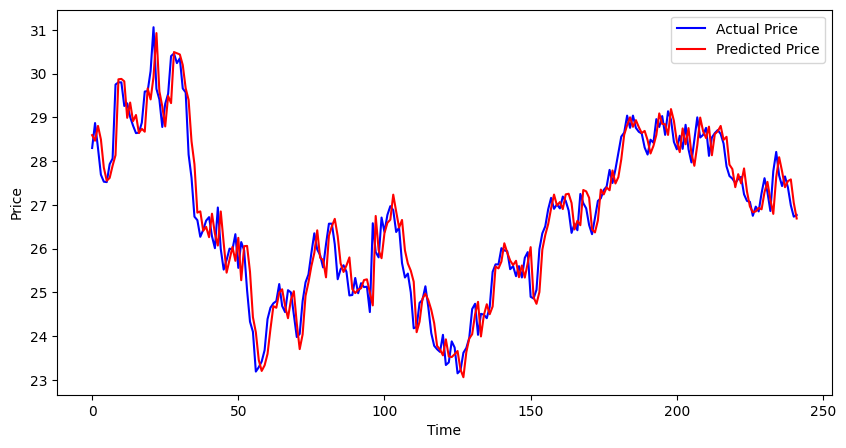

ITUB4.SA
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Pré-processando os dados...
Construindo as sequências de dados...
Construindo as sequências...
Construindo o modelo Random Forest Regressor...
Treinando o modelo Random Forest Regressor...
Fazendo as previsões com Random Forest Regressor...
Plotando os resultados...


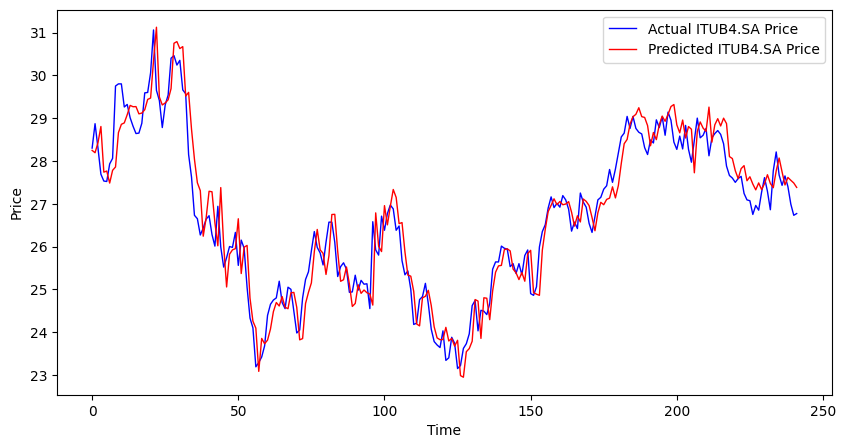

ITUB4.SA
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Pré-processando os dados...
Construindo as sequências de dados...
Construindo as sequências...
Construindo o modelo Random Forest Regressor...
Treinando o modelo Random Forest Regressor...
Fazendo as previsões com Random Forest Regressor...
Plotando os resultados...


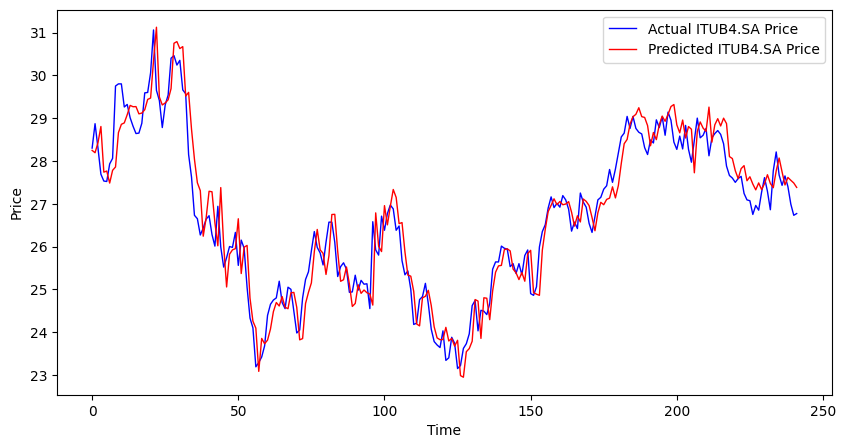

Pré-processando os dados...
Construindo as sequências de dados...
Construindo as sequências...
Construindo o modelo Random Forest Regressor...
Treinando o modelo Random Forest Regressor com médias móveis...
Fazendo as previsões com Random Forest Regressor...
Plotando os resultados...


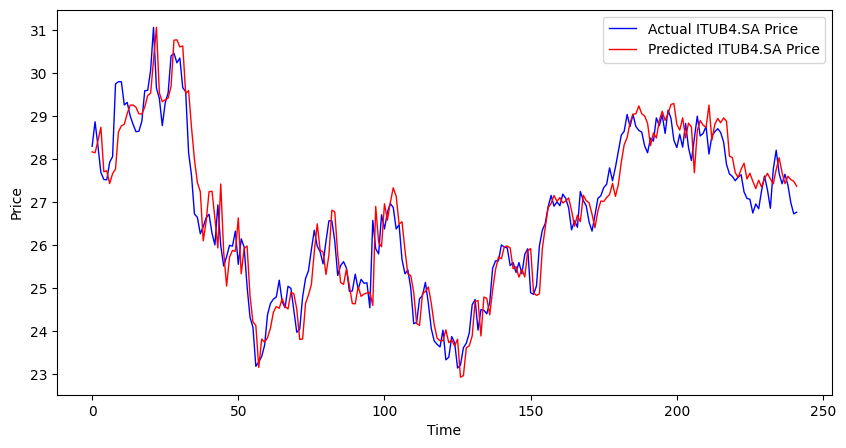

Plotando os resultados...


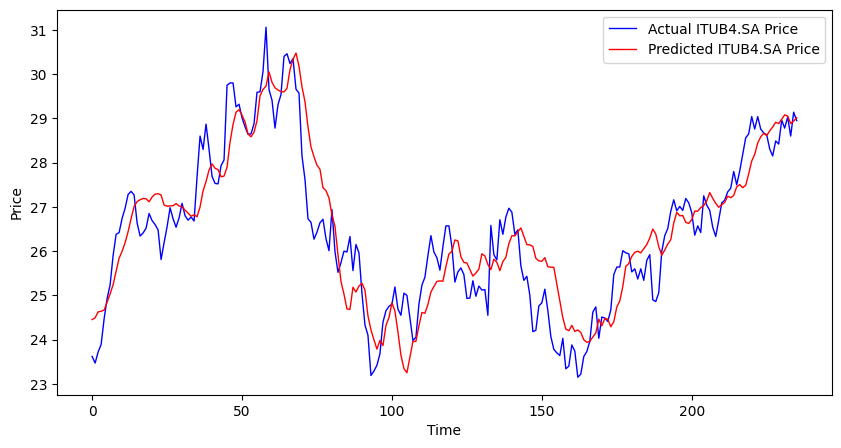

A correlação entre y_test_1d e predicted é: 0.9019873748783841
MAE: 0.6172937338479076
MSE: 0.5963673163997805
RMSE: 0.7722482220114077
R²: 0.8096797799050268
Calculando a correlação...
Calculando a correlação...


,Métrica,SVR,Random Forest,Random Forest_Medias,GLM
0,Correlação,0.901987,0.956452,0.955939,0.964105
1,MAE,0.617294,0.429670,0.431166,0.368961
2,MSE,0.596367,0.299316,0.301533,0.231397
3,RMSE,0.772248,0.547097,0.547097,0.481038
4,R²,0.809680,0.906633,0.905942,0.927819


In [111]:
# -*- coding: utf-8 -*-
"""svr.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1KjiimiSBdMdGFPkNaAOG8qm_oOgiIemH
"""

!pip install mplfinance

import yfinance as yf
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from scipy.stats import pearsonr
import mplfinance as mpf
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from datetime import date, timedelta

from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

def download_data_day(ticker, start_date, end_date):
    print("Baixando os dados...")
    data = yf.download(ticker, start_date, end_date, interval='1d')
    return data

# Etapa 2: Pré-processamento dos dados
print("Pré-processando os dados...")
def preprocess_data(data):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))
    return scaled_data, scaler

def create_sequences(data, sequence_length):
    # Etapa 3: Construção do modelo
    print("Construindo o modelo...")
    X, y = [], []
    for i in range(len(data)-sequence_length):
        X.append(data[i:(i+sequence_length), 0])
        y.append(data[i+sequence_length, 0])
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    return X, y

def build_model():
    print("Construindo o modelo SVR...")
    model = SVR(kernel='rbf', C = 5000)  # Você pode escolher o kernel adequado para seu problema
    return model

def train_model(model, X_train, y_train):
    # Reformula os dados de treinamento para que sejam bidimensionais
    X_train_reshaped = X_train.reshape(X_train.shape[0], -1)

    print("Treinando o modelo SVR...")
    model.fit(X_train_reshaped, y_train)
    return model

def predict(model, X_test, scaler=None):
    print("Fazendo as previsões...")
    predicted = model.predict(X_test)
    if scaler is not None:
        predicted = scaler.inverse_transform(predicted.reshape(-1, 1))
    return predicted

def data_training(data):
    sequence_length = 60
    #Pré-processa os dados
    scaled_data, scaler = preprocess_data(data)
    #Cria as sequências de dados
    X, y = create_sequences(scaled_data, sequence_length)
    #Separa os dados de treinamento e teste
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    print(y_train, "   ", y_test)
    return scaled_data, scaler, X_train, X_test, y_train, y_test

def plot_results(actual, predicted, ticker):
    # Etapa 6: Plotando os resultados
    print("Plotando os resultados...")
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111)

    # Define a largura da linha para 1 (você pode ajustar conforme necessário)
    plt.plot(actual, color='blue', label='Actual ' + ticker + ' Price', linewidth=1)
    plt.plot(predicted, color='red', label='Predicted ' + ticker + ' Price', linewidth=1)
    # plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()



def calculate_correlation(actual, predicted):
    # Etapa 7: Cálculo da correlação
    print("Calculando a correlação...")
    corr, _ = pearsonr(actual, predicted)
    return corr


def add_moving_averages(data, window_sizes=[10, 50]):
    for window_size in window_sizes:
        column_name = f'Moving_Average_{window_size}'
        data[column_name] = data['Close'].rolling(window=window_size).mean()
    return data

"""# Download dos Dados"""

ticker = 'ITUB4.SA'
sequence_length = 60
epochs = 20
batch_size = 32

print(ticker)
start_date_day = date.today() - timedelta(days=1915)
end_date_day = date.today() - timedelta(days=91)
data_day = yf.download(tickers=ticker, start=start_date_day, end=end_date_day,interval='1d')
data_test_day = yf.download(tickers=ticker, start=end_date_day, interval='1d')
print(data_day)
print(data_test_day)

"""# Dados escalados"""

scaled_data_1d, scaled_1d, X_train_1d, X_test_1d, y_train_1d, y_test_1d = data_training(data_day)

"""# Treinamento do modelo e previsão"""

epochs = 30
#Constrói o modelo
model_1d = build_model()
#Treina o modelo
model_1d = train_model(model_1d, X_train_1d, y_train_1d)

#Faz previsões
# Antes de fazer as previsões, reformule X_test_1d
X_test_1d_reshaped = X_test_1d.reshape(X_test_1d.shape[0], -1)

# Faz previsões
predicted = predict(model_1d, X_test_1d_reshaped, scaled_1d)
print(y_test_1d)
#Desfaz a escala dos dados
y_test_1d = scaled_1d.inverse_transform(y_test_1d.reshape(-1, 1))
print(y_test_1d)

"""Predicted Future com técnica Seed

```
# Isto está formatado como código
```


"""

def predict_future(model, X_test, scaler, n_steps=90):
    if len(X_test) < n_steps:
        n_steps = len(X_test) - 1
    for i in range(n_steps):
        last_90 = X_test[-n_steps:]
        predicted = model.predict(last_90)
        predicted = scaler.inverse_transform(predicted)

        # Adicione apenas o último valor da previsão a X_test
        X_test = np.append(X_test, predicted[0, -1])

    return scaler.inverse_transform(X_test[-n_steps:])

predicted_future = predict_future(model_1d, X_test_1d.reshape(1, -1), scaled_1d)

"""#RF Regressor"""

from sklearn.ensemble import RandomForestRegressor

def preprocess_data(data):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))
    return scaled_data, scaler

def create_sequences(data, sequence_length):
    print("Construindo as sequências...")
    X_rf, y_rf = [], []
    for i in range(len(data) - sequence_length):
        X_rf.append(data[i:(i + sequence_length), 0])
        y_rf.append(data[i + sequence_length, 0])
    X_rf, y_rf = np.array(X_rf), np.array(y_rf)
    return X_rf, y_rf

def build_model_rf():
    print("Construindo o modelo Random Forest Regressor...")
    model_rf = RandomForestRegressor(n_estimators=100, random_state=0)  # Você pode ajustar os hiperparâmetros conforme necessário
    return model_rf

def train_model_rf(model_rf, X_train_rf, y_train_rf):
    print("Treinando o modelo Random Forest Regressor...")
    model_rf.fit(X_train_rf, y_train_rf)
    return model_rf

def predict_rf(model_rf, X_test_rf, scaler=None):
    print("Fazendo as previsões com Random Forest Regressor...")
    predicted_rf = model_rf.predict(X_test_rf)
    if scaler is not None:
        predicted_rf = scaler.inverse_transform(predicted_rf.reshape(-1, 1))
    return predicted_rf

def data_training_rf(data_rf):
    sequence_length_rf = 60
    print("Pré-processando os dados...")
    scaled_data_rf, scaler_rf = preprocess_data(data_rf)
    print("Construindo as sequências de dados...")
    X_rf, y_rf = create_sequences(scaled_data_rf, sequence_length_rf)
    train_size_rf = int(len(X_rf) * 0.8)
    X_train_rf, X_test_rf = X_rf[:train_size_rf], X_rf[train_size_rf:]
    y_train_rf, y_test_rf = y_rf[:train_size_rf], y_rf[train_size_rf:]
    return scaled_data_rf, scaler_rf, X_train_rf, X_test_rf, y_train_rf, y_test_rf

def plot_results_rf(actual_rf, predicted_rf, ticker_rf):
    print("Plotando os resultados...")
    fig_rf = plt.figure(figsize=(10, 5))
    ax_rf = fig_rf.add_subplot(111)
    plt.plot(actual_rf, color='blue', label='Actual ' + ticker_rf + ' Price', linewidth=1)
    plt.plot(predicted_rf, color='red', label='Predicted ' + ticker_rf + ' Price', linewidth=1)
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

def calculate_correlation_rf(actual_rf, predicted_rf):
    print("Calculando a correlação...")
    corr_rf, _ = pearsonr(actual_rf, predicted_rf)
    return corr_rf

def add_moving_averages_rf(data_rf, window_sizes_rf=[10, 50]):
    for window_size_rf in window_sizes_rf:
        column_name_rf = f'Moving_Average_{window_size_rf}'
        data_rf[column_name_rf] = data_rf['Close'].rolling(window=window_size_rf).mean()
    return data_rf

"""#GLM

"""

import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from datetime import date, timedelta

# Função para baixar os dados
def download_data_glm(ticker_glm, start_date_glm, end_date_glm):
    print("Baixando os dados...")
    data_glm = yf.download(ticker_glm, start=start_date_glm, end=end_date_glm, interval='1d')
    return data_glm

# Função para pré-processar os dados
def preprocess_data_glm(data_glm):
    scaler_glm = MinMaxScaler(feature_range=(0, 1))
    scaled_data_glm = scaler_glm.fit_transform(data_glm['Close'].values.reshape(-1, 1))
    return scaled_data_glm, scaler_glm

# Função para criar sequências de dados
def create_sequences_glm(data_glm, sequence_length_glm):
    X_glm, y_glm = [], []
    for i in range(len(data_glm) - sequence_length_glm):
        X_seq_glm = data_glm[i:(i + sequence_length_glm), 0]
        y_seq_glm = data_glm[i + sequence_length_glm, 0]
        X_glm.append(X_seq_glm)
        y_glm.append(y_seq_glm)
    X_glm, y_glm = np.array(X_glm), np.array(y_glm)
    return X_glm, y_glm

# Função para construir o modelo GLM (Regressão Linear)
def build_model_glm():
    return LinearRegression()

# Função para treinar o modelo
def train_model_glm(model_glm, X_train_glm, y_train_glm):
    model_glm.fit(X_train_glm, y_train_glm)
    return model_glm

# Função para fazer previsões
def predict_glm(model_glm, X_test_glm):
    return model_glm.predict(X_test_glm)

# Função para calcular métricas de avaliação
def evaluate_glm(y_true_glm, y_pred_glm):
    mae_glm = mean_absolute_error(y_true_glm, y_pred_glm)
    mse_glm = mean_squared_error(y_true_glm, y_pred_glm)
    rmse_glm = np.sqrt(mse_glm)
    r2_glm = r2_score(y_true_glm, y_pred_glm)
    correlation_glm = np.corrcoef(y_test_glm.flatten(), y_pred_glm.flatten())[0, 1]
    return correlation_glm, mae_glm, mse_glm, rmse_glm, r2_glm

# Parâmetros
ticker_glm = 'ITUB4.SA'
start_date_glm = date.today() - timedelta(days=1900)
end_date_glm = date.today() - timedelta(days=30)
sequence_length_glm = 60

# Baixar os dados
data_glm = download_data_glm(ticker_glm, start_date_glm, end_date_glm)

# Pré-processar os dados
scaled_data_glm, scaler_glm = preprocess_data_glm(data_glm)

# Criar sequências de dados
X_glm, y_glm = create_sequences_glm(scaled_data_glm, sequence_length_glm)

# Separar dados de treinamento e teste
train_size_glm = int(len(X_glm) * 0.8)
X_train_glm, X_test_glm = X_glm[:train_size_glm], X_glm[train_size_glm:]
y_train_glm, y_test_glm = y_glm[:train_size_glm], y_glm[train_size_glm:]

# Construir o modelo
model_glm = build_model_glm()

# Treinar o modelo
model_glm = train_model_glm(model_glm, X_train_glm, y_train_glm)

# Fazer previsões
y_pred_glm = predict_glm(model_glm, X_test_glm)

# Desfazer a escala das previsões
y_pred_glm = scaler_glm.inverse_transform(y_pred_glm.reshape(-1, 1))

# Desfazer a escala dos dados de teste
y_test_glm = scaler_glm.inverse_transform(y_test_glm.reshape(-1, 1))

# Calcular métricas de avaliação
correlation_glm, mae_glm, mse_glm, rmse_glm, r2_glm = evaluate_glm(y_test_glm, y_pred_glm)

print("Correlation", correlation_glm)
print("MAE:", mae_glm)
print("MSE:", mse_glm)
print("RMSE:", rmse_glm)
print("R²:", r2_glm)

# Plotar resultados
plt.figure(figsize=(10, 5))
plt.plot(y_test_glm, label='Actual Price', color='blue')
plt.plot(y_pred_glm, label='Predicted Price', color='red')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

ticker_rf = 'ITUB4.SA'
sequence_length_rf = 60

print(ticker_rf)
start_date_day_rf = date.today() - timedelta(days=1900)
end_date_day_rf = date.today() - timedelta(days=30)
data_day_rf = yf.download(tickers=ticker_rf, start=start_date_day_rf, end=end_date_day_rf, interval='1d')
data_test_day_rf = yf.download(tickers=ticker_rf, start=end_date_day_rf, interval='1d')

scaled_data_1d_rf, scaled_1d_rf, X_train_1d_rf, X_test_1d_rf, y_train_1d_rf, y_test_1d_rf = data_training_rf(data_day_rf)

model_1d_rf = build_model_rf()
model_1d_rf = train_model_rf(model_1d_rf, X_train_1d_rf, y_train_1d_rf)

predicted_rf = predict_rf(model_1d_rf, X_test_1d_rf)

# Desfaz a escala dos dados
y_test_1d_rf = scaled_1d_rf.inverse_transform(y_test_1d_rf.reshape(-1, 1))

# Desfaz a escala dos dados
predicted_rf = scaled_1d_rf.inverse_transform(predicted_rf.reshape(-1, 1))

# Plotar resultados
plot_results_rf(y_test_1d_rf, predicted_rf, ticker_rf)

ticker_rf = 'ITUB4.SA'
sequence_length_rf = 60

print(ticker_rf)
start_date_day_rf = date.today() - timedelta(days=1900)
end_date_day_rf = date.today() - timedelta(days=30)
data_day_rf = yf.download(tickers=ticker_rf, start=start_date_day_rf, end=end_date_day_rf, interval='1d')
data_test_day_rf = yf.download(tickers=ticker_rf, start=end_date_day_rf, interval='1d')

scaled_data_1d_rf, scaled_1d_rf, X_train_1d_rf, X_test_1d_rf, y_train_1d_rf, y_test_1d_rf = data_training_rf(data_day_rf)

model_1d_rf = build_model_rf()
model_1d_rf = train_model_rf(model_1d_rf, X_train_1d_rf, y_train_1d_rf)

predicted_rf = predict_rf(model_1d_rf, X_test_1d_rf)

# Desfaz a escala dos dados
y_test_1d_rf = scaled_1d_rf.inverse_transform(y_test_1d_rf.reshape(-1, 1))

# Desfaz a escala dos dados
predicted_rf = scaled_1d_rf.inverse_transform(predicted_rf.reshape(-1, 1))

# Plotar resultados
plot_results_rf(y_test_1d_rf, predicted_rf, ticker_rf)

from sklearn.impute import SimpleImputer

def data_training_rf_med(data_rf):
    sequence_length_rf = 60
    print("Pré-processando os dados...")
    scaled_data_rf_med, scaler_rf_med = preprocess_data(data_rf)
    print("Construindo as sequências de dados...")
    X_rf_med, y_rf_med = create_sequences_rf(scaled_data_rf_med, sequence_length_rf)
    train_size_rf_med = int(len(X_rf_med) * 0.8)
    X_train_rf_med, X_test_rf_med = X_rf_med[:train_size_rf_med], X_rf_med[train_size_rf_med:]
    y_train_rf_med, y_test_rf_med = y_rf_med[:train_size_rf_med], y_rf_med[train_size_rf_med:]

    # Tratar valores ausentes
    imputer = SimpleImputer(strategy='mean')
    X_train_rf_med = imputer.fit_transform(X_train_rf_med)
    X_test_rf_med = imputer.transform(X_test_rf_med)

    return scaled_data_rf_med, scaler_rf_med, X_train_rf_med, X_test_rf_med, y_train_rf_med, y_test_rf_med

def create_sequences_rf(data_rf, sequence_length_rf):
    print("Construindo as sequências...")
    X_rf_med, y_rf_med = [], []
    for i in range(len(data_rf) - sequence_length_rf):
        X_seq_rf = data_rf[i:(i + sequence_length_rf), 0]

        # Adiciona as médias móveis como atributos adicionais
        for window_size_rf in [10, 50]:
            rolling_mean = pd.Series(data_rf[i:(i + sequence_length_rf), 0]).rolling(window=window_size_rf).mean()
            X_seq_rf = np.append(X_seq_rf, rolling_mean)

        X_rf_med.append(X_seq_rf)
        y_rf_med.append(data_rf[i + sequence_length_rf, 0])
    X_rf_med, y_rf_med = np.array(X_rf_med), np.array(y_rf_med)
    return X_rf_med, y_rf_med

def build_model_rf_med():
    print("Construindo o modelo Random Forest Regressor com médias móveis...")
    model_rf_med = RandomForestRegressor(n_estimators=100, random_state=0)  # Você pode ajustar os hiperparâmetros conforme necessário
    return model_rf_med

def train_model_rf_med(model_rf_med, X_train_rf_med, y_train_rf_med):
    print("Treinando o modelo Random Forest Regressor com médias móveis...")
    model_rf_med.fit(X_train_rf_med, y_train_rf_med)
    return model_rf_med

def predict_rf_med(model_rf_med, X_test_rf_med, scaler=None):
    print("Fazendo as previsões com Random Forest Regressor com médias móveis...")
    predicted_rf_med = model_rf_med.predict(X_test_rf_med)
    if scaler is not None:
        predicted_rf_med = scaler.inverse_transform(predicted_rf_med.reshape(-1, 1))
    return predicted_rf_med

def calculate_correlation_rf_med(actual_rf_med, predicted_rf_med):
    print("Calculando a correlação com Random Forest Regressor com médias móveis...")
    corr_rf_med, _ = pearsonr(actual_rf_med, predicted_rf_med)
    return corr_rf_med

def add_moving_averages_rf_med(data_rf, window_sizes_rf=[10, 50]):
    for window_size_rf in window_sizes_rf:
        column_name_rf = f'Moving_Average_{window_size_rf}_rf_med'
        data_rf[column_name_rf] = data_rf['Close'].rolling(window=window_size_rf).mean()
    return data_rf
# ...

# Treinamento do modelo Random Forest Regressor com médias móveis
scaled_data_1d_rf_med, scaled_1d_rf_med, X_train_1d_rf_med, X_test_1d_rf_med, y_train_1d_rf_med, y_test_1d_rf_med = data_training_rf_med(data_day_rf)

model_1d_rf_med = build_model_rf()
model_1d_rf_med = train_model_rf_med(model_1d_rf_med, X_train_1d_rf_med, y_train_1d_rf_med)

predicted_rf_med = predict_rf(model_1d_rf_med, X_test_1d_rf_med)

# Desfaz a escala dos dados
y_test_1d_rf_med = scaled_1d_rf_med.inverse_transform(y_test_1d_rf_med.reshape(-1, 1))

# Desfaz a escala dos dados
predicted_rf_med = scaled_1d_rf_med.inverse_transform(predicted_rf_med.reshape(-1, 1))

# Plotar resultados
plot_results_rf(y_test_1d_rf_med, predicted_rf_med, ticker_rf)

"""# Plotando *dados*"""

plot_results(y_test_1d, predicted, ticker)

"""# Correlação"""

def calculate_correlation(predicted_future, y_test_1d):
    # Calcular a correlação entre predicted_future e y_test_1d
    correlation = pd.Series(predicted_future).corr(pd.Series(y_test_1d))

    return correlation

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import math

# print(" Length of y_test_1d:", len(y_test_1d))
# print(" Length of predicted:", len(predicted))

# Reshape both arrays to have compatible shapes for correlation calculation
y_test_1d = y_test_1d.reshape(-1)  # Flatten y_test_1d
predicted = predicted.reshape(-1)  # Flatten y_test_future

# Now both arrays should have the same shape and can be used for correlation calculation
correlation = calculate_correlation(y_test_1d, predicted)
print(f"A correlação entre y_test_1d e predicted é: {correlation}")

# Calcular o Erro Médio Absoluto (MAE)
mae = mean_absolute_error(y_test_1d, predicted)
print(f"MAE: {mae}")

# Calcular o Erro Médio Quadrático (MSE)
mse = mean_squared_error(y_test_1d, predicted)
print(f"MSE: {mse}")

# Calcular a Raiz do Erro Médio Quadrático (RMSE)
rmse = math.sqrt(mse)
print(f"RMSE: {rmse}")

# Calcular o R² (Coeficiente de Determinação)
r2 = r2_score(y_test_1d, predicted)
print(f"R²: {r2}")

# Reshape both arrays to have compatible shapes for correlation calculation
y_test_1d = y_test_1d.reshape(-1)  # Flatten y_test_1d
predicted = predicted.reshape(-1)  # Flatten y_test_future
# Métricas do SVR
corr_svr = calculate_correlation(predicted, y_test_1d)
mae_svr = mean_absolute_error(y_test_1d, predicted)
mse_svr = mean_squared_error(y_test_1d, predicted)
rmse_svr = math.sqrt(mse_svr)
r2_svr = r2_score(y_test_1d, predicted)

y_test_1d_rf = y_test_1d_rf.reshape(-1)  # Flatten y_test_1d
predicted_rf = predicted_rf.reshape(-1)  # Flatten y_test_future
# Métricas do Random Forest Regressor
corr_rf = calculate_correlation_rf(predicted_rf, y_test_1d_rf)
mae_rf = mean_absolute_error(y_test_1d_rf, predicted_rf)
mse_rf = mean_squared_error(y_test_1d_rf, predicted_rf)
rmse_rf = math.sqrt(mse_rf)
r2_rf = r2_score(y_test_1d_rf, predicted_rf)


# Reshape both arrays to have compatible shapes for correlation calculation
y_test_1d_rf_med = y_test_1d_rf_med.reshape(-1)  # Flatten y_test_1d
predicted_rf_med = predicted_rf_med.reshape(-1)  # Flatten y_test_future

# Métricas do Random Forest Regressor com medias moveis
corr_rf_med = calculate_correlation_rf(predicted_rf_med, y_test_1d_rf_med)
mae_rf_med = mean_absolute_error(y_test_1d_rf_med, predicted_rf_med)
mse_rf_med = mean_squared_error(y_test_1d_rf_med, predicted_rf_med)
rmse_rf_med = math.sqrt(mse_rf)
r2_rf_med = r2_score(y_test_1d_rf, predicted_rf_med)

# Criar um DataFrame para comparar as métricas
data = {
    'Métrica': ['Correlação', 'MAE', 'MSE', 'RMSE', 'R²'],
    'SVR': [corr_svr, mae_svr, mse_svr, rmse_svr, r2_svr],
    'Random Forest': [corr_rf, mae_rf, mse_rf, rmse_rf, r2_rf],
    'Random Forest_Medias': [corr_rf_med, mae_rf_med, mse_rf_med, rmse_rf_med, r2_rf_med],
    'GLM': [correlation_glm, mae_glm, mse_glm, rmse_glm, r2_glm]
}

df_metrics = pd.DataFrame(data)
data_itub4 = df_metrics
display(df_metrics)

In [112]:
print("\n\t\tITAÚ ")
display(data_itub4)

print("\n\t\tBOVA11 ")
display(data_bova11)

print("\n\t\tPETROBRÁS ")
display(data_petr4)


		ITAÚ 


,Métrica,SVR,Random Forest,Random Forest_Medias,GLM
0,Correlação,0.901987,0.956452,0.955939,0.964105
1,MAE,0.617294,0.429670,0.431166,0.368961
2,MSE,0.596367,0.299316,0.301533,0.231397
3,RMSE,0.772248,0.547097,0.547097,0.481038
4,R²,0.809680,0.906633,0.905942,0.927819



		BOVA11 


,Métrica,SVR,Random Forest,Random Forest_Medias,GLM
0,Correlação,0.866437,0.960445,0.960390,0.960175
1,MAE,2.789976,1.240279,1.246014,1.262398
2,MSE,12.474779,2.521467,2.521879,2.579649
3,RMSE,3.531965,1.587913,1.587913,1.606129
4,R²,0.466660,0.922304,0.922291,0.920511



		PETROBRÁS 


,Métrica,SVR,Random Forest,Random Forest_Medias,GLM
0,Correlação,0.924537,0.956647,0.952175,0.967060
1,MAE,2.264679,0.716321,0.753201,0.642100
2,MSE,7.000292,1.010458,1.133398,0.773763
3,RMSE,2.645806,1.005215,1.005215,0.879638
4,R²,0.538949,0.914644,0.904259,0.934638
